In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import sys
import os
from torch.utils.data import DataLoader

/u/kazumak2/.conda/envs/pytorch-env/lib/python3.9/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
# compactly add project src and analysis/zero-shot to sys.path if not already present
for rel in ('src', 'analysis/forecasting'):
    p = os.path.abspath(os.path.join(os.getcwd(), rel))
    if p not in sys.path:
        sys.path.append(p)

# now imports that rely on those paths
from utils import SequentialDeepONetDataset
from helper import convert2dim, compute_metrics_region, load_model_experiment, plot_field_region, load_model_experiment_deeponet
from forecasting_analysis import fit

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Load Datasets

In [3]:
# input data shape (8400, 12)
# trunk shape (361 * 181, 2)
# target shape (8400, 361 * 181)

#input_data = np.random.randn(8400, 12)        
#trunk = np.random.randn(361 * 181, 2)        
#target = np.random.randn(8400, 361 * 181)

input_data = np.load('data/neutron_data_22yrs.npy')
trunk = np.load('data/grid_points.npy')
target = np.load('data/dose_array.npy')

print("Input data shape:", input_data.shape)
print("Trunk shape:", trunk.shape)
print("Target shape:", target.shape)

Input data shape: (8400, 12)
Trunk shape: (65341, 2)
Target shape: (8400, 65341)


In [4]:
from forecasting_analysis import create_windows_forecasting_with_index

In [5]:
dates = pd.date_range("2001-01-01", "2023-12-31", freq="D")

W, H = 30, 1
X_all, y_all, tgt_idx = create_windows_forecasting_with_index(input_data, target, W, H)
tgt_dates = dates[tgt_idx]

train_mask = (tgt_dates <= pd.Timestamp("2021-12-31"))
val_mask   = (tgt_dates >= pd.Timestamp("2022-01-01")) & (tgt_dates <= pd.Timestamp("2022-12-31"))
test_mask  = (tgt_dates >= pd.Timestamp("2023-01-01")) & (tgt_dates <= pd.Timestamp("2023-12-31"))

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_val,   y_val   = X_all[val_mask],   y_all[val_mask]
X_test,  y_test  = X_all[test_mask],  y_all[test_mask]

# check shapes
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: torch.Size([7640, 30, 12]) torch.Size([7640, 65341])
Validation set: torch.Size([365, 30, 12]) torch.Size([365, 65341])
Test set: torch.Size([365, 30, 12]) torch.Size([365, 65341])


In [6]:
scaler_input = MinMaxScaler()
X_train_scaled = scaler_input.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled   = scaler_input.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled  = scaler_input.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [7]:
# Fit on ALL training pixels (flattened)
scaler_target_global = MinMaxScaler()
scaler_target_global.fit(y_train.reshape(-1, 1))

# Transform sets
y_train_scaled = scaler_target_global.transform(y_train.reshape(-1,1)).reshape(y_train.shape)[..., np.newaxis]
y_val_scaled   = scaler_target_global.transform(y_val.reshape(-1,1)).reshape(y_val.shape)[..., np.newaxis]
y_test_scaled  = scaler_target_global.transform(y_test.reshape(-1,1)).reshape(y_test.shape)[..., np.newaxis]

In [8]:
# create datasets
train_dataset = SequentialDeepONetDataset(X_train_scaled, trunk, y_train_scaled)
val_dataset   = SequentialDeepONetDataset(X_val_scaled,   trunk, y_val_scaled)
test_dataset  = SequentialDeepONetDataset(X_test_scaled,  trunk, y_test_scaled)

# create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## TRON

In [9]:
from helper import init_model, init_model_deeponet
from forecasting_analysis import train_model

In [10]:
tron_model = init_model()
deeponet_model = init_model_deeponet()

In [11]:
# history = train_model(
#     model=deeponet_model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     device=device,
#     scaler_target=scaler_target,
#     num_epochs=200,
#     lr=1e-3,
#     weight_decay=1e-4,
#     scheduler_step=20,
#     scheduler_gamma=0.7,
#     early_stop_patience=10,
#     save_path="analysis/forecasting/deeponet_forecast.pt"
# )

#history = train_model(
#    model=tron_model,
#    train_loader=train_loader,
#    val_loader=val_loader,
#    device=device,
#    num_epochs=200,
#    lr=1e-3,
#    weight_decay=1e-3,
#    scheduler_step=20,
#    scheduler_gamma=0.7,
#    early_stop_patience=20,
#    save_path="analysis/forecasting/dev_model/tron_forecast.pt"
#)

In [12]:
# save history
import pickle
#with open('analysis/forecasting/training_tron_history.pkl', 'wb') as f:
#    pickle.dump(history, f)

# how to load history
def load_history(path, plot=True):
    with open(path, 'rb') as f:
        history = pickle.load(f)

    if plot:
        fig, ax = plt.subplots(1,1, figsize=(8,6))
        ax.plot(history['train_loss'], label='Train Loss')
        ax.plot(history['val_loss'], label='Validation Loss')
        ax.set_yscale('log')
        ax.legend()
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title('Training History')
        plt.show()
    else:
        return history

    return 0

#history_deeponet = load_history('analysis/forecasting/dev_model/training_deeponet_history.pkl', plot=False)
#history_tron = load_history('analysis/forecasting/dev_model/training_tron_history.pkl', plot=False)

In [13]:
#print(np.array(history_deeponet['train_loss']).min(), np.array(history_tron['val_loss']).min())
#print(np.array(history_tron['train_loss']).min(), np.array(history_tron['val_loss']).min())

In [108]:
model = load_model_experiment(model_path = 'analysis/forecasting/ensemble/model_ensemble_2.pt')
#model = load_model_experiment_deeponet(model_path = 'analysis/forecasting/deeponet_forecast.pt')

outputs, targets = fit(model.to(device), test_loader, device, scaler_target_global)

Loaded model from analysis/forecasting/ensemble/model_ensemble_2.pt


In [109]:
lon_grid, lat_grid, pred_img = convert2dim(outputs, grid_path='data/grid_points.npy')  # (N,H,W)
_,        _,        targ_img = convert2dim(targets, grid_path='data/grid_points.npy')  # (N,H,W)

print("Prediction image shape:", pred_img.shape)
print("Target image shape:", targ_img.shape)

Prediction image shape: (365, 181, 361)
Target image shape: (365, 181, 361)


In [110]:
l2, ssim = compute_metrics_region(pred_img, targ_img, lon_grid, lat_grid, region_extent=[-180, 180, -90, 90])

Region [-180, 180, -90, 90]
Mean rel-L2 (%): 5.597215
Mean SSIM: 0.3874281115509094


In [111]:
# 365 days covering 2023 test period
dates = pd.date_range("2023-01-01", "2023-12-31", freq="D")

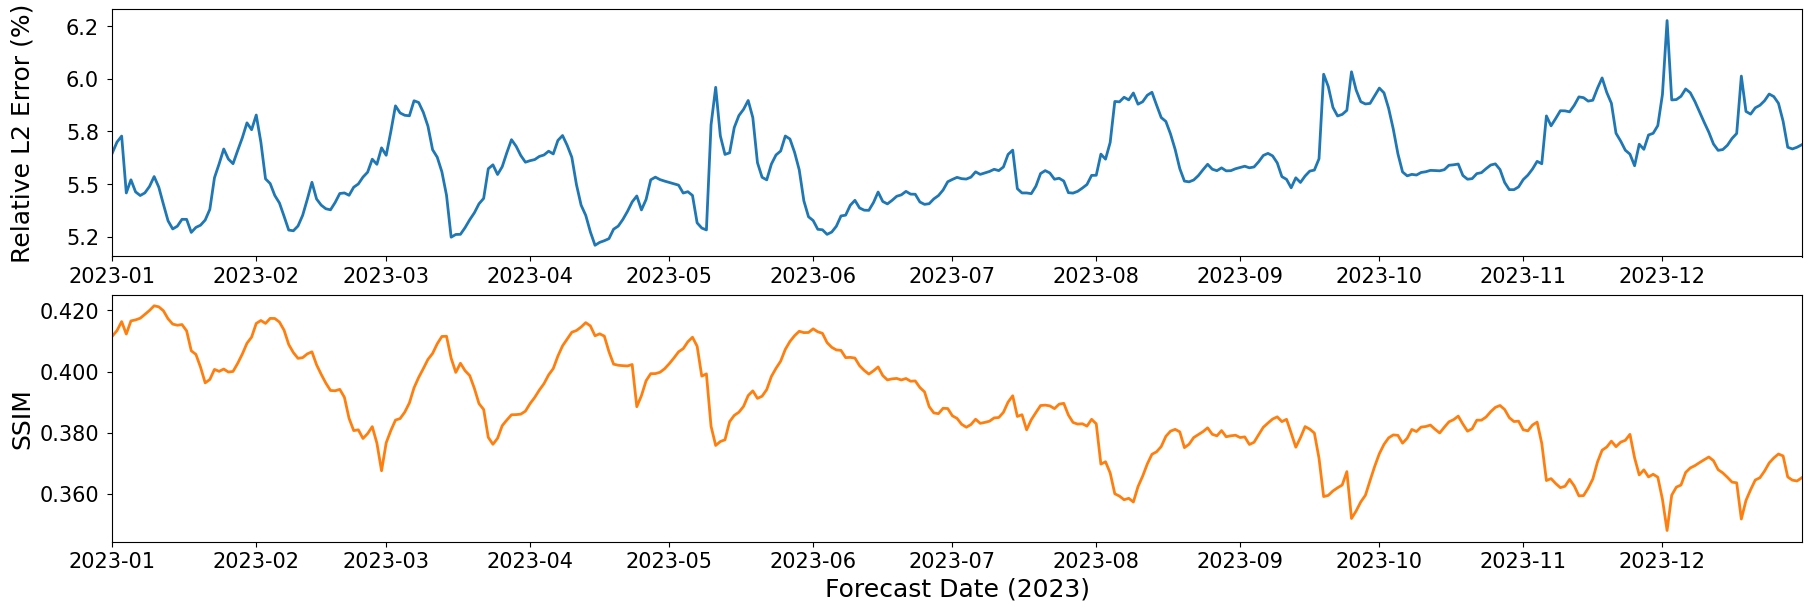

In [112]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

fig, ax = plt.subplots(2, 1, figsize=(18, 6), sharex=True, constrained_layout=True)

# month ticks/labels (use '%b' for Jan/Feb..., or '%Y-%m' for 2023-01)
month_locator = mdates.MonthLocator(interval=1)
month_fmt = mdates.DateFormatter('%Y-%m')

# --- top: Relative L2 ---
ax[0].plot(dates, l2, lw=2, color='tab:blue')
ax[0].set_ylabel('Relative L2 Error (%)', fontsize=18)
ax[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))

# --- bottom: SSIM ---
ax[1].plot(dates, ssim, lw=2, color='tab:orange')
ax[1].set_ylabel('SSIM', fontsize=18)
ax[1].set_xlabel('Forecast Date (2023)', fontsize=18)
ax[1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))

# apply the SAME x tick locator/formatter to BOTH axes
for a in ax:
    a.xaxis.set_major_locator(month_locator)
    a.xaxis.set_major_formatter(month_fmt)
    # <-- CRUCIAL: re-enable top-axis labels even with sharex
    a.tick_params(axis='x', which='both', labelbottom=True, rotation=0)
    a.yaxis.set_ticks_position('left')
    a.yaxis.set_label_position('left')
    a.tick_params(axis='y', pad=6)
    # thick font size for x and y ticks
    a.tick_params(axis='x', labelsize=15)
    a.tick_params(axis='y', labelsize=15)

# nice alignment and limits
fig.align_ylabels(ax)
ax[1].set_xlim(dates[0], dates[-1])

#plt.savefig('analysis/forecasting/forecast_metrics_2023.png', dpi=300)
plt.show()


In [104]:
# find 50th percentile dates for L2 and SSIM
l2_50th = np.percentile(l2, 50)
ssim_50th = np.percentile(ssim, 50)

idx_50pct = np.argmin(np.abs(l2 - l2_50th))
idx_50pct_ssim = np.argmin(np.abs(ssim - ssim_50th))

print("50th percentile Relative L2 Error: %.2f%% on %s" % (l2_50th, dates[idx_50pct].strftime('%Y-%m-%d')))
print("50th percentile SSIM: %.4f on %s" % (ssim_50th, dates[idx_50pct_ssim].strftime('%Y-%m-%d')))

# find the minimum ssim
min_ssim_idx = np.argmin(ssim)
print("Minimum SSIM: %.4f on %s" % (ssim[min_ssim_idx], dates[min_ssim_idx].strftime('%Y-%m-%d')))

50th percentile Relative L2 Error: 1.32% on 2023-11-17
50th percentile SSIM: 0.9151 on 2023-10-23
Minimum SSIM: 0.9069 on 2023-12-02


In [105]:
date = dates[min_ssim_idx]

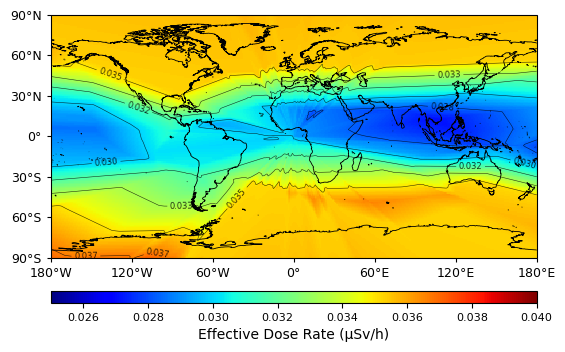

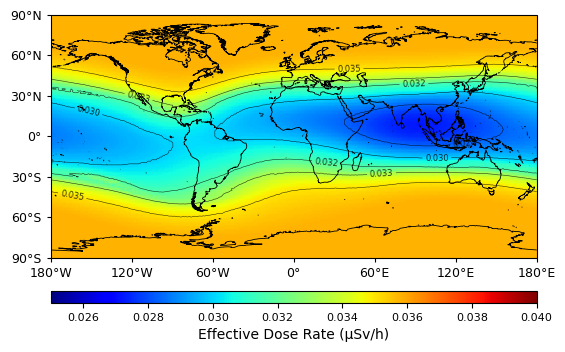

In [106]:
# convert index to date
date = dates[idx_50pct].date()

plot_field_region(
    lon_grid, lat_grid, pred_img, i=idx_50pct,
    #title=f"test {date}",
    units_label="Effective Dose Rate (µSv/h)",
    region_extent=[-180, 180, -90, 90],
    vmin=0.025, vmax=0.040,
    tick_step=(60, 30),
    add_contour=True, contour_levels=np.linspace(0.025, 0.040, 10),
    mark_equator_meridian=False,
    show_borders=False,
    cmap= 'jet',
    #savepath='analysis/forecasting/prediction_global.png'
)

plot_field_region(
    lon_grid, lat_grid, targ_img, i=idx_50pct,
    #title=f"test {date}",
    units_label="Effective Dose Rate (µSv/h)",
    region_extent=[-180, 180, -90, 90],
    vmin=0.025, vmax=0.040,
    tick_step=(60, 30),
    add_contour=True, contour_levels=np.linspace(0.025, 0.040, 10),
    mark_equator_meridian=False,
    show_borders=False,
    cmap= 'jet',
    #savepath='analysis/forecasting/target_global.png'
)

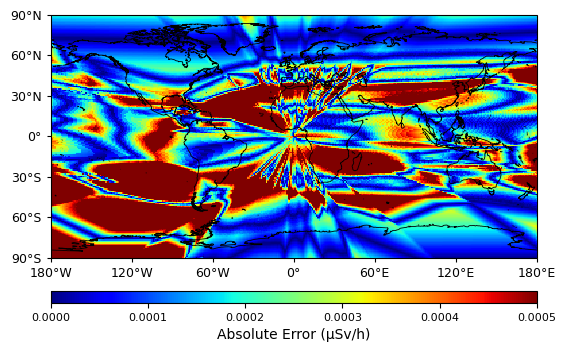

In [107]:
plot_field_region(
    lon_grid, lat_grid, np.abs((targ_img - pred_img)), i=idx_50pct_ssim,
    #title=f"test {date} - Error Map",
    units_label="Absolute Error (µSv/h)",
    region_extent=[-180, 180, -90, 90],
    vmin=0, vmax=5E-4,
    tick_step=(60, 30),
    #add_contour=True, contour_levels=np.linspace(0.025, 0.040, 5),
    mark_equator_meridian=False,
    show_borders=False,
    cmap= 'jet',
    #savepath='analysis/forecasting/tron_error_global_50thpct.png'
)

## Ensemble and Cities

In [23]:
import yaml

In [24]:
with open("analysis/forecasting/yaml/cities.yaml", "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)
    
def wrap_lon(x): return ((x + 180) % 360) - 180
def clip_lat(x): return np.clip(x, -90, 90)

names = [c["name"] for c in cfg["cities"]]
lats  = clip_lat(np.array([c["lat"] for c in cfg["cities"]], dtype=np.float32))
lons  = wrap_lon(np.array([c["lon"] for c in cfg["cities"]], dtype=np.float32))

trunk_cities = np.stack([lats, lons], axis=-1)  # (num_cities, 2)

print("Cities loaded:", names)

Cities loaded: ['New York', 'San Francisco', 'São Paulo', 'London', 'Helsinki', 'Cairo', 'Johannesburg', 'Riyadh', 'Delhi', 'Tokyo', 'Jakarta', 'Sydney']


In [71]:
cities_dataset  = SequentialDeepONetDataset(X_test_scaled,  trunk_cities, y_test_scaled)
cities_dataloader  = DataLoader(cities_dataset, batch_size=1, shuffle=False)

In [72]:
models = []

for i in range(5):
    model_i = load_model_experiment(model_path = f'analysis/forecasting/ensemble/model_ensemble_{i}.pt')
    model_i = model_i.to(device)
    models.append(model_i.eval())

Loaded model from analysis/forecasting/ensemble/model_ensemble_0.pt
Loaded model from analysis/forecasting/ensemble/model_ensemble_1.pt
Loaded model from analysis/forecasting/ensemble/model_ensemble_2.pt
Loaded model from analysis/forecasting/ensemble/model_ensemble_3.pt
Loaded model from analysis/forecasting/ensemble/model_ensemble_4.pt


In [87]:
import torch
import numpy as np

@torch.no_grad()
def ensemble_predict_raw(models, branch_batch, trunk_batch, device, squeeze_last=True):
    preds = []
    branch_batch = branch_batch.to(device, non_blocking=True)
    trunk_batch  = trunk_batch.to(device,  non_blocking=True)
    for m in models:
        m.eval()
        y = m(branch_batch, trunk_batch)          # [B, M] or [B, M, 1]
        if squeeze_last and y.dim() == 3 and y.size(-1) == 1:
            y = y.squeeze(-1)
        preds.append(y.unsqueeze(0))              # prepend K
    return torch.cat(preds, dim=0)                # [K, B, M]

# Run across the year
P_days = []   # list of [K, 1, M]
Y_days = []   # list of [1, M] (scaled targets, if present)
for branch_batch, trunk_batch, target_batch in cities_dataloader:
    P = ensemble_predict_raw(models, branch_batch, trunk_batch, device)  # [K, 1, M]
    P_days.append(P.cpu())
    Y_days.append(target_batch.cpu())

# Stack → [N, K, M] and [N, M]
P_all = torch.cat(P_days, dim=1).permute(1,0,2)   # [K, N, M] -> permute to [N, K, M]
Y_all = torch.cat(Y_days, dim=0)                  # [N, M]
# If you prefer numpy:
P_all = P_all.numpy()
Y_all = Y_all.numpy()

mean_scaled = P_all.mean(axis=1)          # [N, M]  (N=365 days, M=12 cities)
std_scaled  = P_all.std(axis=1, ddof=0)   # [N, M]